# Sheldon User Conversation Analysis
## Multiple Users Analysis

This notebook analyzes:
- What questions the users asked Sheldon
- Whether Sheldon actually helped them
- Conversation patterns and usage statistics

Analyzing users:
- 636ae19451ca690013861179
- 66a9262c55a933735f9f9c0d
- 65effe807274a0644f4fb6b5
- 66b4007d495d86027459cd53
- 65cc082efe78300013c61d65
- 5f06172d300bbb0012e72143

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from pymongo import MongoClient
from bson.objectid import ObjectId
from dotenv import load_dotenv
import os
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
# Load environment variables
load_dotenv()

# Get MySQL connection URL and modify for synchronous connection
mysql_url = os.getenv('MYSQL_DATABASE_URL')
mysql_url_sync = mysql_url.replace('aiomysql', 'pymysql')

# Create MySQL engine
engine = create_engine(mysql_url_sync)

print("MySQL connection established")

MySQL connection established


In [4]:
# Connect to MongoDB
mongo_uri = os.getenv('MONGO_DATABASE_URI')
mongo_client = MongoClient(mongo_uri)
db = mongo_client['UnifiedCare']
employees_collection = db['employees']
role_assignments_collection = db['role_assignments']

print("MongoDB connection established")

MongoDB connection established


## Part 1: Get User Details

In [5]:
# User IDs to analyze
target_user_ids = [
    '636ae19451ca690013861179',
    '66a9262c55a933735f9f9c0d',
    '65effe807274a0644f4fb6b5',
    '66b4007d495d86027459cd53',
    '65cc082efe78300013c61d65',
    '5f06172d300bbb0012e72143'
]

# Function to get user details from MongoDB
def get_user_details(user_id_str):
    try:
        user_obj_id = ObjectId(user_id_str)
        user_doc = employees_collection.find_one({"_id": user_obj_id})
        
        if user_doc:
            # Get roles from role_assignments collection
            role_docs = list(role_assignments_collection.find({"memberId": user_obj_id}))
            unique_roles = list(set([doc.get('roleType') for doc in role_docs if doc.get('roleType')]))
            roles_str = ', '.join(sorted(unique_roles)) if unique_roles else 'N/A'
            
            return {
                'User ID': user_id_str,
                'Name': f"{user_doc.get('firstName', '')} {user_doc.get('lastName', '')}".strip() or 'N/A',
                'Email': user_doc.get('email', 'N/A'),
                'Roles': roles_str,
                'Status': user_doc.get('status', 'N/A')
            }
        else:
            return {
                'User ID': user_id_str,
                'Name': 'Not Found',
                'Email': 'N/A',
                'Roles': 'N/A',
                'Status': 'N/A'
            }
    except Exception as e:
        return {
            'User ID': user_id_str,
            'Name': f'Error: {str(e)}',
            'Email': 'N/A',
            'Roles': 'N/A',
            'Status': 'N/A'
        }

# Get details for all users
print("User Information:")
print("="*80)
all_user_info = []
for user_id in target_user_ids:
    user_info = get_user_details(user_id)
    all_user_info.append(user_info)
    print(f"\nUser ID: {user_info['User ID']}")
    print(f"  Name: {user_info['Name']}")
    print(f"  Email: {user_info['Email']}")
    print(f"  Roles: {user_info['Roles']}")
    print(f"  Status: {user_info['Status']}")

# Create summary DataFrame
df_users = pd.DataFrame(all_user_info)
print("\n" + "="*80)
print("Users Summary:")
display(df_users)

User Information:

User ID: 636ae19451ca690013861179
  Name: N/A
  Email: sheena.bling@ihealthlabs.com
  Roles: RD
  Status: ACTIVATED

User ID: 66a9262c55a933735f9f9c0d
  Name: N/A
  Email: maria.blandon@ihealthlabs.com
  Roles: RD
  Status: ACTIVATED

User ID: 65effe807274a0644f4fb6b5
  Name: N/A
  Email: sandy.liang@ihealthlabs.com
  Roles: CA
  Status: ACTIVATED

User ID: 66b4007d495d86027459cd53
  Name: N/A
  Email: yichen.sun@ihealthlabs.com
  Roles: RD
  Status: ACTIVATED

User ID: 65cc082efe78300013c61d65
  Name: N/A
  Email: stephanie.refugio@ihealthlabs.com
  Roles: CA
  Status: ACTIVATED

User ID: 5f06172d300bbb0012e72143
  Name: N/A
  Email: lunar.holiday@gmail.com
  Roles: CLINICAL_MANAGER, PROVIDER
  Status: ACTIVATED

Users Summary:


,User ID,Name,Email,Roles,Status
0,636ae19451ca690013861179,N/A,sheena.bling@ihealthlabs.com,RD,ACTIVATED
1,66a9262c55a933735f9f9c0d,N/A,maria.blandon@ihealthlabs.com,RD,ACTIVATED
2,65effe807274a0644f4fb6b5,N/A,sandy.liang@ihealthlabs.com,CA,ACTIVATED
3,66b4007d495d86027459cd53,N/A,yichen.sun@ihealthlabs.com,RD,ACTIVATED
4,65cc082efe78300013c61d65,N/A,stephanie.refugio@ihealthlabs.com,CA,ACTIVATED
5,5f06172d300bbb0012e72143,N/A,lunar.holiday@gmail.com,"CLINICAL_MANAGER, PROVIDER",ACTIVATED


## Part 2: Query All Sheldon Conversations

In [6]:
# Query all Sheldon conversations for all target users
# action_type = 'Sheldon' represents Sheldon conversations
query = text("""
    SELECT
        id,
        user_id,
        timestamp,
        session_id,
        agent_id,
        question,
        answer,
        reaction,
        reaction_timestamp,
        comment,
        prompt_tokens,
        completion_tokens,
        total_tokens,
        llm_process_time,
        retrieval_results,
        llm_answer,
        action_type,
        patient_id
    FROM ai.chat_history
    WHERE user_id IN :user_ids
        AND action_type = 'Sheldon'
    ORDER BY user_id, timestamp ASC
""")

with engine.connect() as conn:
    df_conversations = pd.read_sql(query, conn, params={'user_ids': tuple(target_user_ids)})

print(f"\nTotal Sheldon conversations across all users: {len(df_conversations)}")
print(f"Date range: {df_conversations['timestamp'].min()} to {df_conversations['timestamp'].max()}")
print(f"Users with conversations: {df_conversations['user_id'].nunique()}")

# Per-user summary
user_summary = df_conversations.groupby('user_id').agg({
    'id': 'count',
    'session_id': 'nunique',
    'timestamp': ['min', 'max'],
    'total_tokens': 'sum',
    'reaction': lambda x: x.notna().sum()
}).round(2)

user_summary.columns = ['Total_Conversations', 'Unique_Sessions', 'First_Use', 'Last_Use', 'Total_Tokens', 'Reactions_Given']
print("\n" + "="*80)
print("Per-User Summary:")
display(user_summary)

print("\n" + "="*80)
print("Sample data:")
df_conversations.head(10)


Total Sheldon conversations across all users: 541
Date range: 2024-09-06 20:35:29 to 2025-10-29 23:13:59
Users with conversations: 6

Per-User Summary:


,Total_Conversations,Unique_Sessions,First_Use,Last_Use,Total_Tokens,Reactions_Given
user_id,,,,,,
5f06172d300bbb0012e72143,54,33,2024-09-20 02:24:35,2025-10-29 23:13:59,82493.0,5
636ae19451ca690013861179,156,79,2024-09-13 19:35:40,2025-08-22 19:44:15,459796.0,0
65cc082efe78300013c61d65,57,29,2024-09-06 20:35:29,2025-09-24 22:43:52,110542.0,0
65effe807274a0644f4fb6b5,78,46,2024-09-12 20:10:19,2025-10-14 00:19:35,133226.0,0
66a9262c55a933735f9f9c0d,130,89,2024-09-09 21:58:55,2025-09-26 22:07:15,296258.0,1
66b4007d495d86027459cd53,66,34,2024-09-24 22:42:13,2025-09-05 02:00:27,180155.0,0



Sample data:


,id,user_id,timestamp,session_id,agent_id,question,answer,reaction,reaction_timestamp,comment,prompt_tokens,completion_tokens,total_tokens,llm_process_time,retrieval_results,llm_answer,action_type,patient_id
0,206,5f06172d300bbb0012e72143,2024-09-20 02:24:35,479222fe-4daf-4fb4-99ef-70d3ab81fe5c,1,"aFib- getting up SOB, one month ago. asthma, throat closing sleep apnea -unsure 5-6 hrs sleep pe...",It appears that several health concerns are converging to affect your well-being significantly. ...,5.0,2024-09-20 02:25:04,None,1821.0,700.0,2521.0,None,"{""retrievalResults"":[{""content"":{""text"":""Page 177 Endocrine abnormalities Cardiac...","{""answer"":""It appears that several health concerns are converging to affect your well-being sign...",Sheldon,None
1,207,5f06172d300bbb0012e72143,2024-09-20 02:38:40,479222fe-4daf-4fb4-99ef-70d3ab81fe5c,1,good,I'm glad you found the information helpful! If you have any more questions or need further assis...,NaN,NaT,None,1813.0,33.0,1846.0,None,"{""retrievalResults"":[{""content"":{""text"":""## 7 khúc mắc về bệnh cao huyết áp (7 Myths About High ...","{""answer"":""I'm glad you found the information helpful! If you have any more questions or need fu...",Sheldon,None
2,220,5f06172d300bbb0012e72143,2024-09-24 00:16:37,156d19f8-a55b-4eb6-8a03-cdebcd597f06,1,hi my blood pressure monitor exploded,It sounds like you've experienced a very serious issue with your blood pressure monitor. Firstly...,5.0,2024-09-24 00:19:47,None,1146.0,215.0,1361.0,None,"{""retrievalResults"":[{""content"":{""text"":""The blood pressure monitor does not inflate\n ...","{""answer"":""It sounds like you've experienced a very serious issue with your blood pressure monit...",Sheldon,None
3,344,5f06172d300bbb0012e72143,2024-10-04 04:21:07,9bd4e3d7-3ebf-4226-a380-2d09de7afc13,1,hi,Hello! How can I assist you today?,NaN,NaT,None,1471.0,11.0,1482.0,None,"{""retrievalResults"":[{""content"":{""text"":"", CDE July 28, 2023 August 22, 2024 Bạn đang kết nối wi...","{""answer"":""Hello! How can I assist you today?"",""citations"":[]}",Sheldon,None
4,345,5f06172d300bbb0012e72143,2024-10-04 04:21:17,9bd4e3d7-3ebf-4226-a380-2d09de7afc13,1,i ha ve a low read,"If you're indicating that your blood glucose levels are currently low, it's important to address...",NaN,NaT,None,990.0,154.0,1144.0,None,"{""retrievalResults"":[{""content"":{""text"":""(Carbohydrates, They're Complex!) ## Obteniendo la Cant...","{""answer"":""If you're indicating that your blood glucose levels are currently low, it's important...",Sheldon,None
5,983,5f06172d300bbb0012e72143,2024-10-11 23:24:08,009f9d75-3c7d-4905-a7eb-2c22f90164bb,1,hi,Hello! How can I assist you today?,NaN,NaT,None,1471.0,11.0,1482.0,None,"{""retrievalResults"":[{""content"":{""text"":"", CDE July 28, 2023 August 22, 2024 Bạn đang kết nối wi...","{""answer"":""Hello! How can I assist you today?"",""citations"":[]}",Sheldon,None
6,984,5f06172d300bbb0012e72143,2024-10-11 23:24:20,009f9d75-3c7d-4905-a7eb-2c22f90164bb,1,shuroom,"Hello! It seems there might be a typo in your query. Are you asking about **shrooms**, perhaps i...",NaN,NaT,None,1503.0,49.0,1552.0,None,"{""retrievalResults"":[{""content"":{""text"":""Kosher restaurants are closed on Shabbat, the sabbath o...","{""answer"":""Hello! It seems there might be a typo in your query. Are you asking about **shrooms**...",Sheldon,None
7,996,5f06172d300bbb0012e72143,2024-10-12 02:42:14,e96595c2-efbb-455e-bc07-6c835b5d20e5,1,hi,Hello! How can I assist you today?,NaN,NaT,None,1471.0,11.0,1482.0,None,"{""retrievalResults"":[{""content"":{""text"":"", CDE July 28, 2023 August 22, 2024 Bạn đang kết nối wi...","{""answer"":""Hello! How can I assist you today?"",""citations"":[]}",Sheldon,None
8,1001,5f06172d300bbb0012e72143,2024-10-12 02:45:38,e96595c2-efbb-455e-bc07-6c835b5d20e5,1,I want to eat after 1 am,"Eating late at night, especially after 1 AM, can be managed with some careful choices to avoid d...",NaN,NaT,None,1509.0,395.0,1904.0,None,"{""re

## Part 3: Usage Statistics Overview

In [7]:
# Calculate usage statistics
stats = {
    'Total Conversations': len(df_conversations),
    'Unique Sessions': df_conversations['session_id'].nunique(),
    'Conversations per Session (avg)': round(len(df_conversations) / df_conversations['session_id'].nunique(), 2) if df_conversations['session_id'].nunique() > 0 else 0,
    'Total Tokens Used': df_conversations['total_tokens'].sum(),
    'Avg Tokens per Conversation': round(df_conversations['total_tokens'].mean(), 2),
    'First Use Date': df_conversations['timestamp'].min(),
    'Last Use Date': df_conversations['timestamp'].max(),
    'Days Active': (df_conversations['timestamp'].max() - df_conversations['timestamp'].min()).days,
    'Reactions Given': df_conversations['reaction'].notna().sum(),
    'Positive Reactions': (df_conversations['reaction'] == 'thumbs_up').sum(),
    'Negative Reactions': (df_conversations['reaction'] == 'thumbs_down').sum()
}

print("\n=== Usage Statistics ===")
for key, value in stats.items():
    print(f"{key}: {value}")


=== Usage Statistics ===
Total Conversations: 541
Unique Sessions: 310
Conversations per Session (avg): 1.75
Total Tokens Used: 1262470.0
Avg Tokens per Conversation: 2485.18
First Use Date: 2024-09-06 20:35:29
Last Use Date: 2025-10-29 23:13:59
Days Active: 418
Reactions Given: 6
Positive Reactions: 0
Negative Reactions: 0


## Part 4: Conversation Timeline

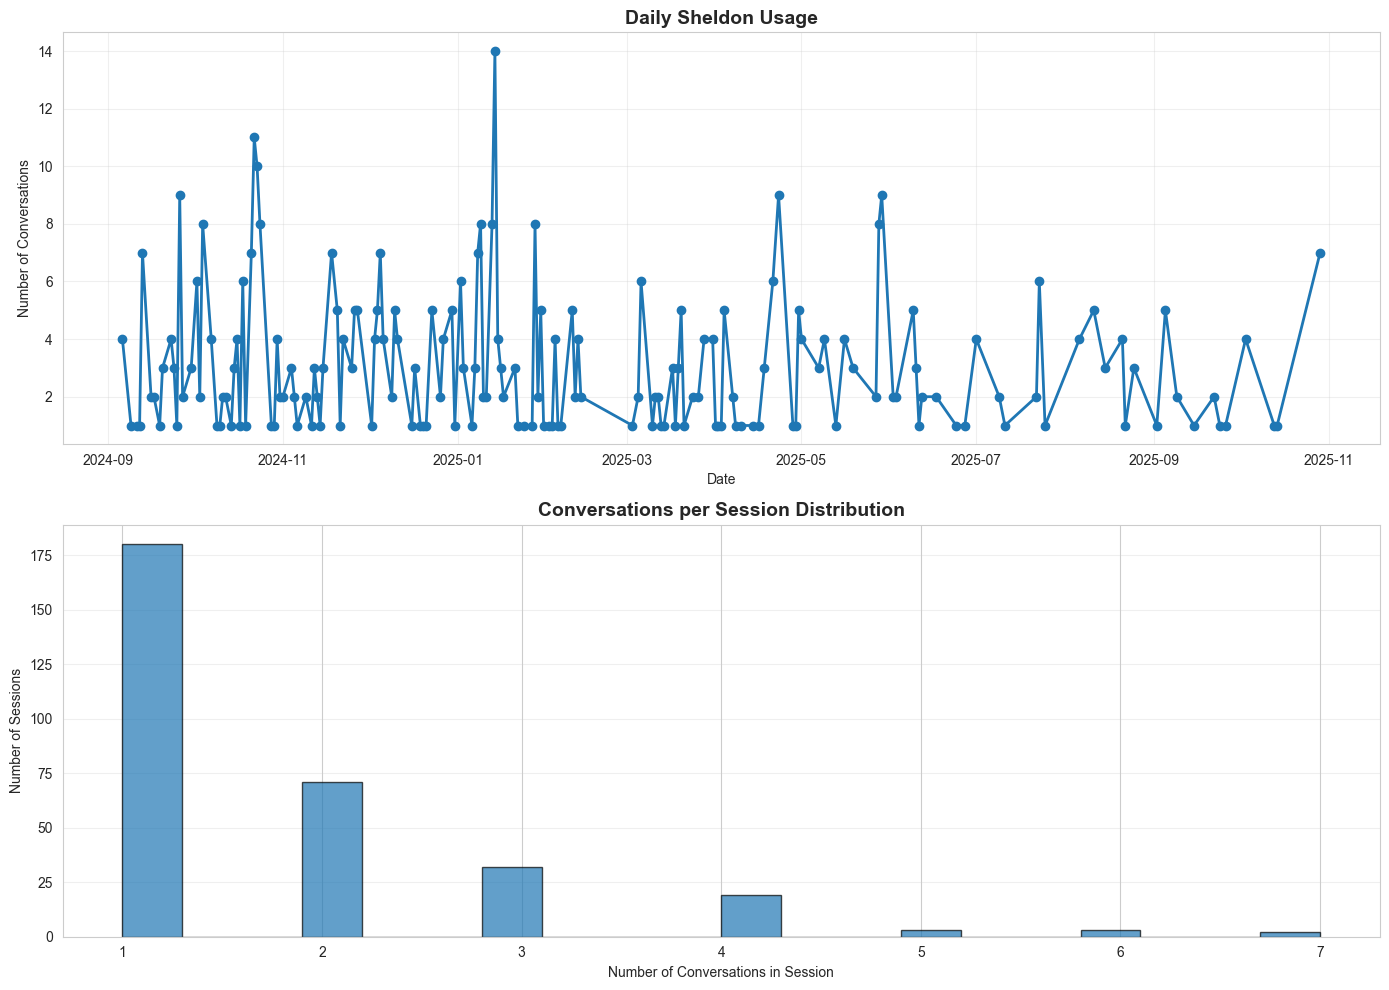

In [8]:
# Create timeline visualization
df_conversations['date'] = pd.to_datetime(df_conversations['timestamp']).dt.date
daily_usage = df_conversations.groupby('date').size().reset_index(name='conversations')
daily_usage['date'] = pd.to_datetime(daily_usage['date'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Daily conversation count
ax1.plot(daily_usage['date'], daily_usage['conversations'], marker='o', linewidth=2, markersize=6)
ax1.set_title('Daily Sheldon Usage', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Conversations')
ax1.grid(True, alpha=0.3)

# Session distribution
session_sizes = df_conversations.groupby('session_id').size().reset_index(name='conv_count')
ax2.hist(session_sizes['conv_count'], bins=20, edgecolor='black', alpha=0.7)
ax2.set_title('Conversations per Session Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Conversations in Session')
ax2.set_ylabel('Number of Sessions')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 5: Reaction Analysis (Helpfulness Indicator)

/var/folders/z0/my7hhtq167b95ptmpwg37sn40000gp/T/ipykernel_41626/1464301580.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


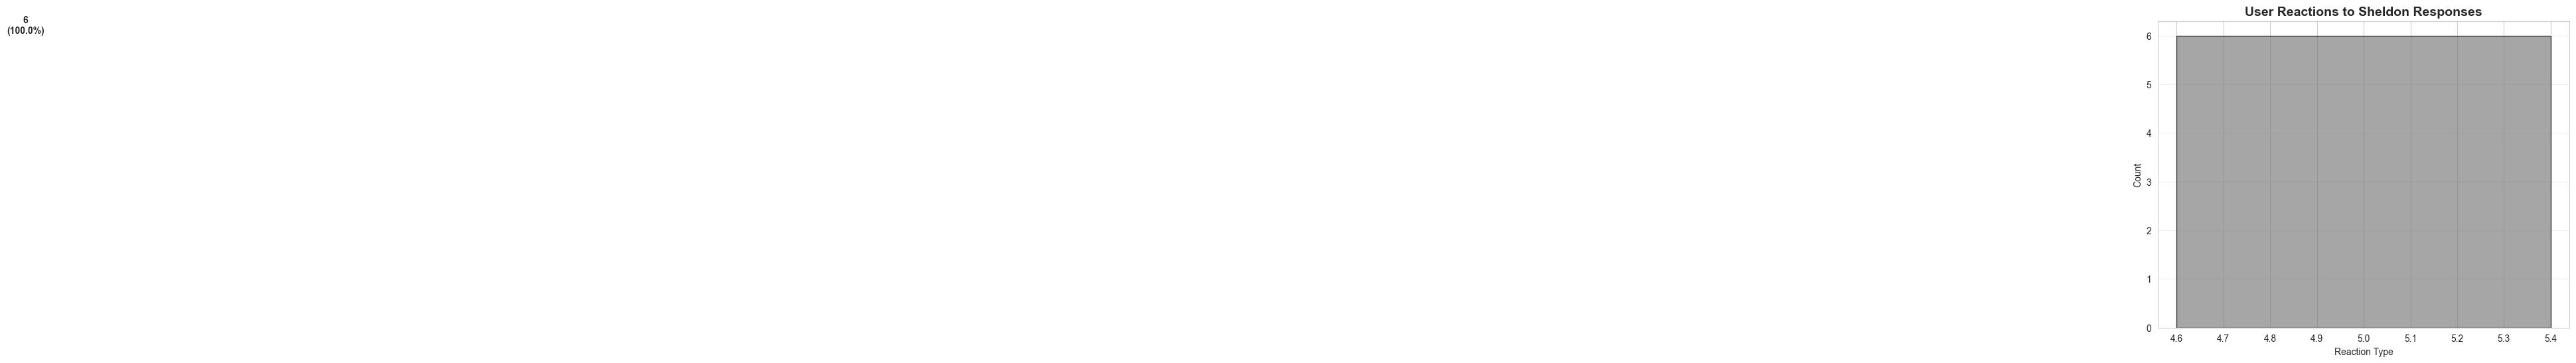


Reaction Summary:


reaction
5.0    6
Name: count, dtype: int64

In [9]:
# Analyze reactions
reaction_counts = df_conversations['reaction'].value_counts()

if len(reaction_counts) > 0:
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['green' if x == 'thumbs_up' else 'red' if x == 'thumbs_down' else 'gray' for x in reaction_counts.index]
    ax.bar(reaction_counts.index, reaction_counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title('User Reactions to Sheldon Responses', fontsize=14, fontweight='bold')
    ax.set_xlabel('Reaction Type')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    total_reactions = reaction_counts.sum()
    for i, (idx, val) in enumerate(reaction_counts.items()):
        percentage = (val / total_reactions) * 100
        ax.text(i, val, f'{val}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nReaction Summary:")
    display(reaction_counts)
else:
    print("No reactions recorded for this user")

## Part 6: Individual User Analysis

Below we analyze each user separately to understand their usage patterns and assess helpfulness.

In [10]:
# Analyze each user individually
for target_user_id in target_user_ids:
    # Filter conversations for this user
    df_user = df_conversations[df_conversations['user_id'] == target_user_id].copy()
    
    if len(df_user) == 0:
        print(f"\n{'='*80}")
        print(f"USER: {target_user_id}")
        print(f"{'='*80}")
        print("No Sheldon conversations found for this user")
        continue
    
    # Get user info
    user_info = get_user_details(target_user_id)
    
    print(f"\n{'='*80}")
    print(f"USER: {user_info['Name']} ({user_info['Email']})")
    print(f"User ID: {target_user_id}")
    print(f"Roles: {user_info['Roles']}")
    print(f"{'='*80}")
    
    # Calculate statistics
    df_user['date'] = pd.to_datetime(df_user['timestamp']).dt.date
    days_active = max((df_user['timestamp'].max() - df_user['timestamp'].min()).days, 1)
    unique_dates = df_user['date'].nunique()
    unique_sessions = df_user['session_id'].nunique()
    avg_conv_per_session = len(df_user) / unique_sessions
    
    stats = {
        'Total Conversations': len(df_user),
        'Unique Sessions': unique_sessions,
        'Conversations per Session (avg)': round(avg_conv_per_session, 2),
        'Total Tokens Used': int(df_user['total_tokens'].sum()),
        'Avg Tokens per Conversation': round(df_user['total_tokens'].mean(), 2),
        'First Use Date': df_user['timestamp'].min(),
        'Last Use Date': df_user['timestamp'].max(),
        'Days Active': days_active,
        'Days with Activity': unique_dates,
        'Reactions Given': df_user['reaction'].notna().sum(),
        'Positive Reactions': (df_user['reaction'] == 'thumbs_up').sum(),
        'Negative Reactions': (df_user['reaction'] == 'thumbs_down').sum()
    }
    
    print("\nUsage Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value}")
    
    # Helpfulness assessment
    print(f"\n{'-'*80}")
    print("HELPFULNESS ASSESSMENT:")
    print(f"{'-'*80}")
    
    if len(df_user) >= 10 and avg_conv_per_session >= 2:
        print("✓ HIGH ENGAGEMENT: User actively uses Sheldon with multi-turn conversations")
    elif len(df_user) >= 5:
        print("✓ MODERATE ENGAGEMENT: User has used Sheldon multiple times")
    else:
        print("⚠ LOW ENGAGEMENT: Limited usage observed")
    
    if df_user['reaction'].notna().sum() > 0:
        thumbs_up = (df_user['reaction'] == 'thumbs_up').sum()
        thumbs_down = (df_user['reaction'] == 'thumbs_down').sum()
        if thumbs_up > thumbs_down:
            print("✓ POSITIVE FEEDBACK: More positive than negative reactions")
        elif thumbs_down > thumbs_up:
            print("⚠ NEGATIVE FEEDBACK: More negative than positive reactions")
        else:
            print("○ MIXED FEEDBACK: Equal positive and negative reactions")
    else:
        print("○ NO FEEDBACK: User did not provide reactions")
    
    if unique_dates >= 3:
        print("✓ RETURNING USER: Came back multiple days, indicating value")
    elif unique_dates >= 2:
        print("○ REPEAT USER: Used Sheldon on multiple occasions")
    else:
        print("⚠ SINGLE SESSION: Only used once")
    
    # Show sample conversations
    print(f"\n{'-'*80}")
    print(f"Sample Conversations (first 3):")
    print(f"{'-'*80}")
    
    for idx, (_, row) in enumerate(df_user.head(3).iterrows(), 1):
        print(f"\n[{idx}] Time: {row['timestamp']}")
        print(f"Q: {row['question'][:200]}{'...' if len(str(row['question'])) > 200 else ''}")
        print(f"A: {row['answer'][:200]}{'...' if len(str(row['answer'])) > 200 else ''}")
        if pd.notna(row['reaction']):
            print(f"Reaction: {row['reaction']}")
    
    print("\n")


USER: N/A (sheena.bling@ihealthlabs.com)
User ID: 636ae19451ca690013861179
Roles: RD

Usage Statistics:
  Total Conversations: 156
  Unique Sessions: 79
  Conversations per Session (avg): 1.97
  Total Tokens Used: 459796
  Avg Tokens per Conversation: 3045.01
  First Use Date: 2024-09-13 19:35:40
  Last Use Date: 2025-08-22 19:44:15
  Days Active: 343
  Days with Activity: 68
  Reactions Given: 0
  Positive Reactions: 0
  Negative Reactions: 0

--------------------------------------------------------------------------------
HELPFULNESS ASSESSMENT:
--------------------------------------------------------------------------------
✓ MODERATE ENGAGEMENT: User has used Sheldon multiple times
○ NO FEEDBACK: User did not provide reactions
✓ RETURNING USER: Came back multiple days, indicating value

--------------------------------------------------------------------------------
Sample Conversations (first 3):
--------------------------------------------------------------------------------

[1

## Part 7: Comparison Visualization

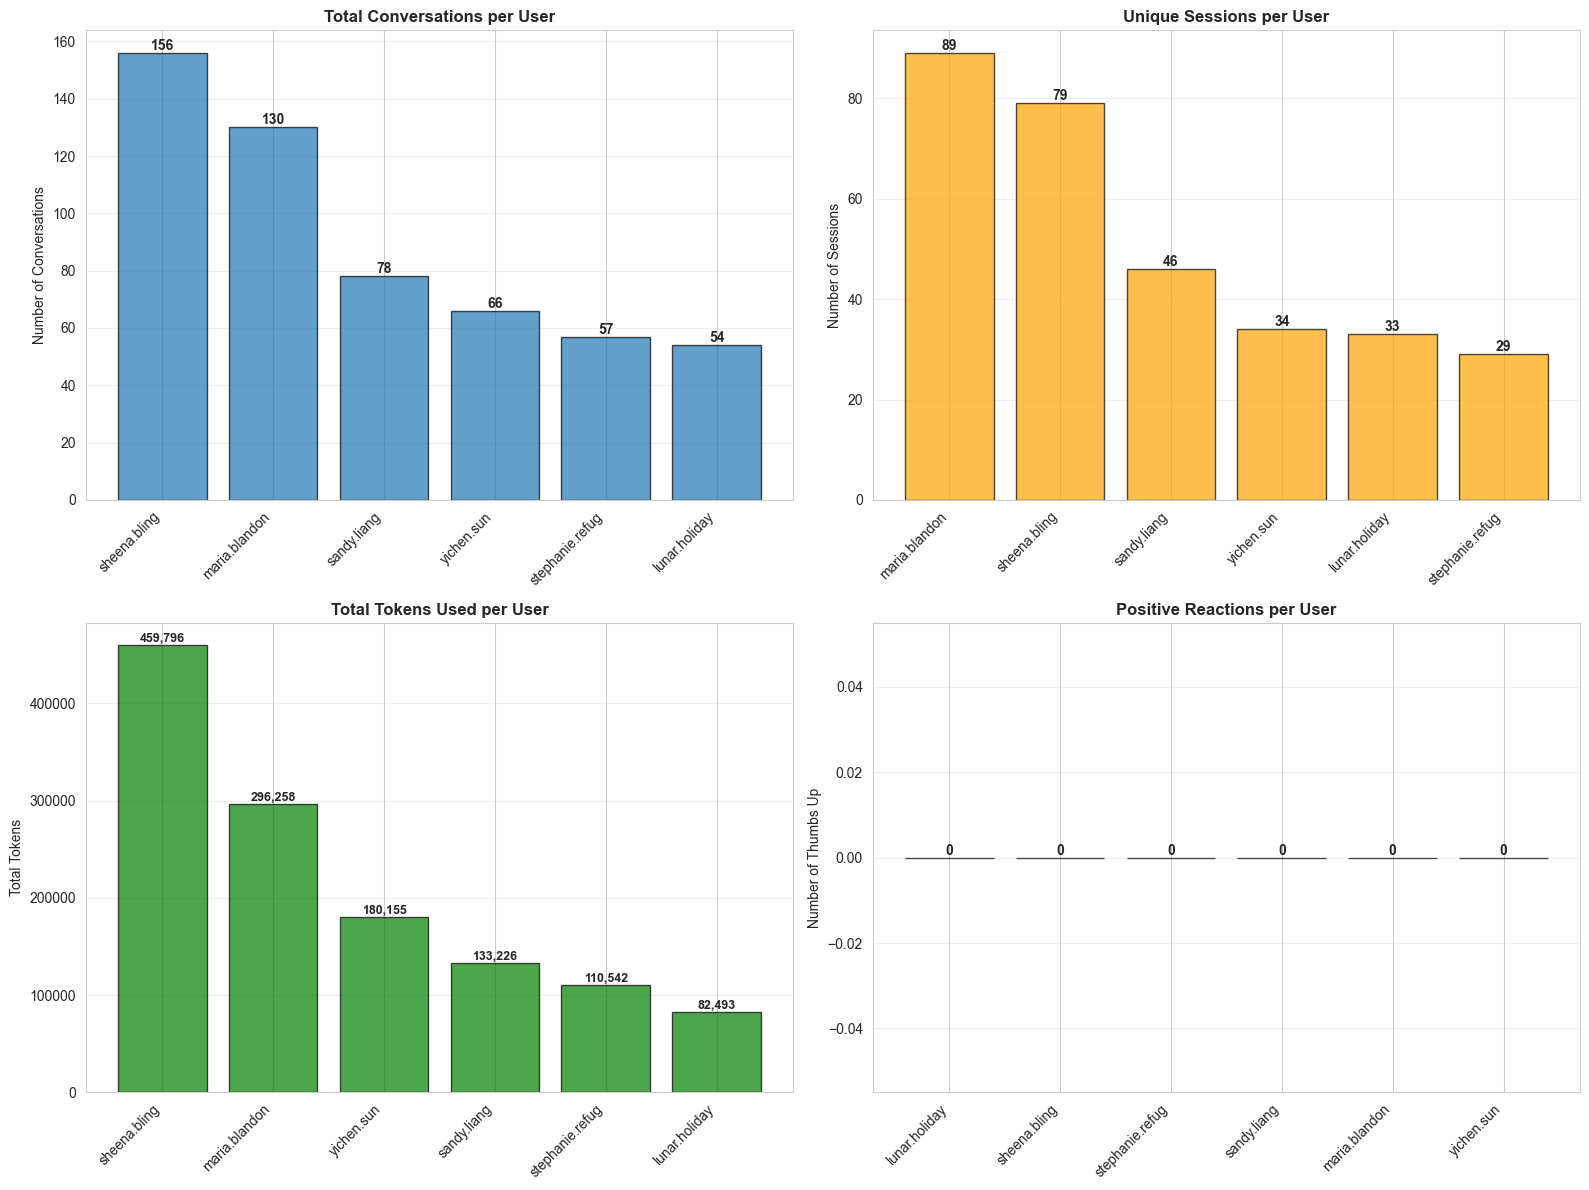

In [11]:
# Create comparison visualizations across all users
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total conversations per user
user_conv_counts = df_conversations.groupby('user_id').size().reset_index(name='conversations')
user_conv_counts = user_conv_counts.sort_values('conversations', ascending=False)

# Add user names
user_conv_counts['name'] = user_conv_counts['user_id'].apply(
    lambda x: get_user_details(x)['Email'].split('@')[0][:15]
)

ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(user_conv_counts)), user_conv_counts['conversations'], alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(user_conv_counts)))
ax1.set_xticklabels(user_conv_counts['name'], rotation=45, ha='right')
ax1.set_title('Total Conversations per User', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Conversations')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(user_conv_counts.iterrows()):
    ax1.text(i, row['conversations'], str(row['conversations']), 
             ha='center', va='bottom', fontweight='bold')

# 2. Unique sessions per user
user_sessions = df_conversations.groupby('user_id')['session_id'].nunique().reset_index(name='sessions')
user_sessions = user_sessions.sort_values('sessions', ascending=False)
user_sessions['name'] = user_sessions['user_id'].apply(
    lambda x: get_user_details(x)['Email'].split('@')[0][:15]
)

ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(user_sessions)), user_sessions['sessions'], alpha=0.7, color='orange', edgecolor='black')
ax2.set_xticks(range(len(user_sessions)))
ax2.set_xticklabels(user_sessions['name'], rotation=45, ha='right')
ax2.set_title('Unique Sessions per User', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Sessions')
ax2.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(user_sessions.iterrows()):
    ax2.text(i, row['sessions'], str(row['sessions']), 
             ha='center', va='bottom', fontweight='bold')

# 3. Total tokens per user
user_tokens = df_conversations.groupby('user_id')['total_tokens'].sum().reset_index(name='tokens')
user_tokens = user_tokens.sort_values('tokens', ascending=False)
user_tokens['name'] = user_tokens['user_id'].apply(
    lambda x: get_user_details(x)['Email'].split('@')[0][:15]
)

ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(user_tokens)), user_tokens['tokens'], alpha=0.7, color='green', edgecolor='black')
ax3.set_xticks(range(len(user_tokens)))
ax3.set_xticklabels(user_tokens['name'], rotation=45, ha='right')
ax3.set_title('Total Tokens Used per User', fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Tokens')
ax3.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(user_tokens.iterrows()):
    ax3.text(i, row['tokens'], f"{int(row['tokens']):,}", 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Reactions per user
user_reactions = df_conversations.groupby('user_id').agg({
    'reaction': lambda x: (x == 'thumbs_up').sum()
}).reset_index()
user_reactions.columns = ['user_id', 'positive_reactions']
user_reactions = user_reactions.sort_values('positive_reactions', ascending=False)
user_reactions['name'] = user_reactions['user_id'].apply(
    lambda x: get_user_details(x)['Email'].split('@')[0][:15]
)

ax4 = axes[1, 1]
bars4 = ax4.bar(range(len(user_reactions)), user_reactions['positive_reactions'], 
                alpha=0.7, color='steelblue', edgecolor='black')
ax4.set_xticks(range(len(user_reactions)))
ax4.set_xticklabels(user_reactions['name'], rotation=45, ha='right')
ax4.set_title('Positive Reactions per User', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Thumbs Up')
ax4.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(user_reactions.iterrows()):
    ax4.text(i, row['positive_reactions'], str(int(row['positive_reactions'])), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Part 8: Export All Conversations

In [12]:
# Export conversations for each user separately
# Only save: user_id, session_id, question, answer

for user_id in target_user_ids:
    df_user = df_conversations[df_conversations['user_id'] == user_id]
    if len(df_user) == 0:
        continue
    
    # Select only the required columns
    df_export = df_user[['user_id', 'session_id', 'question', 'answer']].copy()
    
    # Get user info for filename
    user_info = get_user_details(user_id)
    email_prefix = user_info['Email'].split('@')[0] if user_info['Email'] != 'N/A' else user_id[:8]
    
    # Export to CSV
    output_file = f'user_{email_prefix}_{user_id[:8]}_conversations.csv'
    df_export.to_csv(output_file, index=False)
    print(f"Exported {len(df_export)} conversations for {email_prefix} to: {output_file}")

print("\n" + "="*80)
print("All user conversations exported successfully!")

Exported 156 conversations for sheena.bling to: user_sheena.bling_636ae194_conversations.csv
Exported 130 conversations for maria.blandon to: user_maria.blandon_66a9262c_conversations.csv
Exported 78 conversations for sandy.liang to: user_sandy.liang_65effe80_conversations.csv
Exported 66 conversations for yichen.sun to: user_yichen.sun_66b4007d_conversations.csv
Exported 57 conversations for stephanie.refugio to: user_stephanie.refugio_65cc082e_conversations.csv
Exported 54 conversations for lunar.holiday to: user_lunar.holiday_5f06172d_conversations.csv

All user conversations exported successfully!


In [13]:
## Part 9: AI Analysis of User Conversations

#Using Claude API to analyze each user's conversation patterns and helpfulness.

In [14]:
# Install anthropic library if needed
# !pip install anthropic

import anthropic

# Get Claude API key
claude_key = os.getenv('CLAUDE_KEY')
client = anthropic.Anthropic(api_key=claude_key)

print("Claude API client initialized")

Claude API client initialized


In [15]:
# Function to analyze user conversations with Claude
def analyze_user_conversations(user_id, df_user_convs):
    """
    Use Claude API to analyze a user's Sheldon conversations
    """
    # Prepare conversation summary
    conv_text = f"User ID: {user_id}\n"
    conv_text += f"Total Conversations: {len(df_user_convs)}\n\n"
    conv_text += "Conversations:\n"
    conv_text += "="*80 + "\n\n"
    
    for idx, row in df_user_convs.iterrows():
        conv_text += f"[Conversation {idx+1}]\n"
        conv_text += f"Time: {row['timestamp']}\n"
        conv_text += f"Session: {row['session_id']}\n"
        conv_text += f"Question: {row['question']}\n"
        conv_text += f"Answer: {row['answer']}\n"
        conv_text += "-"*80 + "\n\n"
    
    # Create prompt for Claude
    prompt = f"""Please analyze the following Sheldon AI assistant conversations for a healthcare user.

{conv_text}

Please provide a comprehensive analysis covering:

1. **Question Patterns**: What types of questions is this user asking? (e.g., clinical questions, workflow questions, technical issues, patient care, etc.)

2. **Topic Analysis**: What are the main topics or themes across all conversations?

3. **Complexity Assessment**: Are the questions simple/routine or complex/specialized?

4. **Sheldon's Helpfulness**: Based on the answers provided, does Sheldon appear to be genuinely helpful to this user? Provide specific examples.

5. **User Engagement**: Does the user seem satisfied based on conversation patterns? (e.g., follow-up questions, diverse topics, repeated usage)

6. **Key Insights**: Any notable patterns, concerns, or recommendations?

Please provide a structured analysis with specific examples from the conversations."""

    try:
        # Call Claude API - trying 
        message = client.messages.create(
            model="claude-sonnet-4-5",
            max_tokens=2000,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        
        return message.content[0].text
    
    except Exception as e:
        return f"Error analyzing conversations: {str(e)}"

print("Analysis function defined")

Analysis function defined


In [16]:
# Analyze each user's conversations with Claude
all_analyses = []

for user_id in target_user_ids:
    df_user = df_conversations[df_conversations['user_id'] == user_id].copy()
    
    if len(df_user) == 0:
        print(f"\nSkipping {user_id} - No conversations found")
        continue
    
    user_info = get_user_details(user_id)
    
    print(f"\n{'='*80}")
    print(f"Analyzing: {user_info['Name']} ({user_info['Email']})")
    print(f"User ID: {user_id}")
    print(f"Total Conversations: {len(df_user)}")
    print(f"{'='*80}")
    print("Calling Claude API...")
    
    # Get analysis from Claude
    analysis = analyze_user_conversations(user_id, df_user)
    
    print("\nANALYSIS:")
    print(analysis)
    print("\n")
    
    # Store analysis
    all_analyses.append({
        'user_id': user_id,
        'name': user_info['Name'],
        'email': user_info['Email'],
        'roles': user_info['Roles'],
        'total_conversations': len(df_user),
        'analysis': analysis
    })

print("\n" + "="*80)
print(f"Completed analysis for {len(all_analyses)} users")
print("="*80)


Analyzing: N/A (sheena.bling@ihealthlabs.com)
User ID: 636ae19451ca690013861179
Total Conversations: 156
Calling Claude API...

ANALYSIS:
# Comprehensive Analysis of Sheldon AI Healthcare Assistant Conversations

## User Profile
- **User ID**: 636ae19451ca690013861179
- **Total Conversations**: 210 (with 156 recorded conversations analyzed)
- **Usage Period**: September 2024 - August 2025
- **User Type**: Healthcare Professional (appears to be a care coordinator, nurse, or dietitian based on question patterns)

---

## 1. Question Patterns

### Primary Question Categories:

**A. Nutritional/Dietary Guidance (45% of conversations)**
- Meal planning and dietary recommendations
- Food-specific questions (protein, fiber, alkaline foods, etc.)
- Managing diet for specific conditions (diabetes, hypertension, cholesterol)
- Examples:
  - "What are good protein food options for someone with diabetes?" (Conv. 90)
  - "How to increase fiber intake?" (Conv. 100)
  - "Mediterranean type diet meal

In [ ]:
# Export all analyses to a CSV file
df_analyses = pd.DataFrame(all_analyses)
analysis_output_file = 'users_claude_analysis.csv'
df_analyses.to_csv(analysis_output_file, index=False)

print(f"Claude analyses exported to: {analysis_output_file}")
print(f"\nTotal users analyzed: {len(df_analyses)}")

# Display summary
print("\n" + "="*80)
print("Analysis Summary:")
display(df_analyses[['user_id', 'name', 'email', 'roles', 'total_conversations']])